In [1]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 8.8 MB/s eta 0:00:00


In [2]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import corner
import time

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, Predictive
from pyro.optim import Adam

from scipy.interpolate import interp1d
import h5py

from astropy.cosmology import FlatLambdaCDM


In [4]:
import math

from numbers import Number
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all, lazy_property
from torch.distributions.normal import Normal

from pyro.distributions.torch_distribution import TorchDistribution

class ZLTN(TorchDistribution):

    arg_constraints = {
        "mu": constraints.real,
        "sigma": constraints.positive,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, mu, sigma, *, validate_args=None):
        self.mu, self.sigma = broadcast_all(mu, sigma)
        self.base_dist =  Normal(0, 1, validate_args=False)
        batch_shape = torch.Size() if isinstance(mu, Number) else self.mu.size()
        super().__init__(batch_shape, validate_args=validate_args)


    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        samples = self.base_dist.sample(shape)
        return self.mu + self.sigma*(self.base_dist.icdf(1 - (1 - self.base_dist.cdf(samples))* self.base_dist.cdf(self.mu/self.sigma)))

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        small_phi = self.base_dist.log_prob((value - self.mu)/self.sigma).exp()
        prob = (1 / self.sigma) * self.base_dist.log_prob((value - self.mu)/self.sigma).exp() / self.base_dist.cdf(self.mu/self.sigma)
        return torch.log(prob)

A_V = f_mu,sigma(x) = mu + sigma Phi^-1 ( 1 - [1 - Phi(x)] * Phi(mu/sigma) )

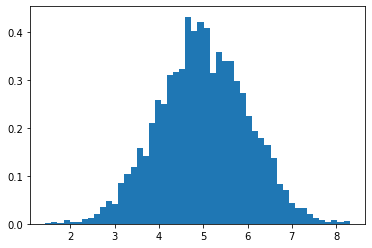

(array([ 151.,  201.,  264.,  303.,  301.,  355.,  440.,  538.,  673.,
        1774.]),
 array([0.00069933, 0.04052363, 0.08034793, 0.12017222, 0.15999652,
        0.19982083, 0.23964512, 0.27946943, 0.31929374, 0.359118  ,
        0.39894232], dtype=float32),
 <BarContainer object of 10 artists>)

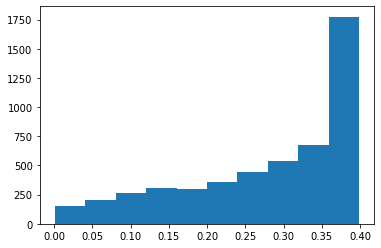

In [5]:
mu = 5
sigma = 1
zltn = ZLTN(mu,sigma)
samples = zltn.sample((5000,))
plt.hist(samples.numpy(), bins = 50, density = True)
plt.show()
plt.hist(np.exp(zltn.log_prob(samples)))

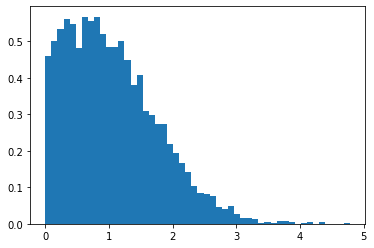

(array([ 104.,  129.,  153.,  193.,  243.,  243.,  287.,  374.,  827.,
        2447.]),
 array([8.8475856e-05, 5.5049516e-02, 1.1001056e-01, 1.6497160e-01,
        2.1993265e-01, 2.7489367e-01, 3.2985473e-01, 3.8481575e-01,
        4.3977681e-01, 4.9473783e-01, 5.4969889e-01], dtype=float32),
 <BarContainer object of 10 artists>)

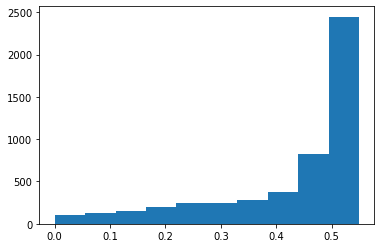

In [6]:
mu = 0.6
sigma = 1
zltn = ZLTN(mu,sigma)
samples = zltn.sample((5000,))
plt.hist(samples.numpy(), bins = 50, density = True)
plt.show()
plt.hist(np.exp(zltn.log_prob(samples)))

Phi(x) = the standard unit normal CDF, and Phi^-1 (y) is its inverse

A_V = f_mu,sigma(x) = mu + sigma Phi^-1 ( 1 - [1 - Phi(x)] * Phi(mu/sigma) )

x = T(Av) = Phi^-1 ( (Phi((Av - mu)/sigma) + Phi(mu/sigma) - 1 ) / Phi(mu/sigma) )

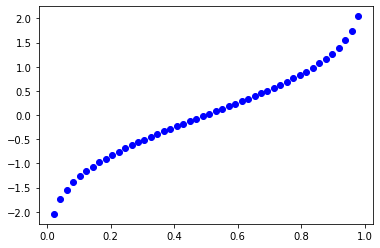

In [7]:
for i in np.linspace(0, 1):
  plt.plot(i, dist.Normal(0,1).icdf(torch.tensor(i)).numpy(), 'bo')

In [8]:
def phi(x):
  return dist.Normal(0,1).cdf(x)

In [9]:
phi(torch.tensor(float('inf')))

tensor(1.)

In [10]:
def phi_inv(x):
  return dist.Normal(0,1).icdf(x)

A_V = f_mu,sigma(x) = mu + sigma Phi^-1 ( 1 - [1 - Phi(x)] * Phi(mu/sigma) )

x = T(Av) = Phi^-1 ( (Phi((Av - mu)/sigma) + Phi(mu/sigma) - 1 ) / Phi(mu/sigma) )

In [11]:
def model(data):
  # mu = torch.tensor(0.1)
  sigma = torch.tensor(0.9)

  # mu = pyro.sample("mu", dist.Normal(0,1))
  # sigma = pyro.sample("sigma", dist.Normal(1,0.2))

  Av = pyro.sample("Av", dist.HalfNormal(sigma))

  # for i in range(len(data)):
  #   pyro.sample("data" + str(i), dist.Normal(Av, 0.002), obs = data[i])

  # Av = mu + sigma * phi_inv(1 - (1 - phi(x)) * phi(mu/sigma))
  # Av ~ ZLTN(mu, sigma)

  # pyro.sample("Av", dist.Normal(Av, 0.5), obs = data)

In [12]:
def guide(data): # truncated normal

  mu_q = pyro.param("mu_q", torch.tensor(0.))
  sigma_q = pyro.param("sigma_q", torch.tensor(1.1), constraint = constraints.positive) 

  # pyro.sample("mu", dist.Normal(mu_q,1))
  # pyro.sample("sigma", dist.Normal(sigma_q,0.2))
  # mu_q = pyro.param("mu_q", torch.tensor(0.1))
  # sigma_q = pyro.param("sigma_q", torch.tensor(0.9), 
  #                      constraint = constraints.positive)

  pyro.sample("Av", ZLTN(mu_q, sigma_q))
  # pyro.sample("Av", dist.HalfNormal(sigma_q))



In [13]:
def train(model, guide, data=None, lr=0.005, n_steps=5000):
    pyro.clear_param_store()
    # adam_params = {"lr": lr}
    # adam = pyro.optim.Adam(adam_params)
    adam = pyro.optim.ClippedAdam({"lr": lr, "betas": (0.95, 0.999)})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for step in range(n_steps):
        loss = svi.step(data)
        # print(loss)
        if step % 1000 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

In [14]:
train(model, guide, n_steps=10000)

[iter 0]  loss: 0.3475
[iter 1000]  loss: -0.0043
[iter 2000]  loss: 0.0780
[iter 3000]  loss: -0.0159
[iter 4000]  loss: 0.0451
[iter 5000]  loss: -0.0051
[iter 6000]  loss: 0.0450
[iter 7000]  loss: 0.0080
[iter 8000]  loss: 0.0097
[iter 9000]  loss: -0.0000


In [15]:
mu_q = pyro.param("mu_q").item()
sigma_q = pyro.param("sigma_q").item()
mu_q, sigma_q

(-0.02451835200190544, 0.9159498810768127)

In [16]:
class ZLTN2D(TorchDistribution):
    arg_constraints = {
        "mu": constraints.real, # this is vector
        "sigma": constraints.positive, # this is a vector
        "rho": constraints.real, # this is a scalar
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, mu, sigma, rho, *, validate_args=None):
        self.mu, self.sigma = broadcast_all(mu, sigma)
        self.rho = rho
        self.base_dist = Normal(0, 1, validate_args=False)
        self.zltn_dist = ZLTN(mu[0], sigma[0])
        batch_shape = torch.Size() if isinstance(mu, Number) else self.mu.size()
        super().__init__(batch_shape, validate_args=validate_args)

    def _transform_to_normal(self, samples, mean, var):
        return self.base_dist.icdf((self.base_dist.cdf((samples - mean)/var) + self.base_dist.cdf(mean/var) - 1.0)/self.base_dist.cdf(mean/var))

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        normal_samples = self.base_dist.sample(sample_shape)
        first_samples = self.zltn_dist.sample(sample_shape)
        E = self.mu[1] + self.rho*(self.sigma[1]/self.sigma[0])*(first_samples - self.mu[0])
        V = (self.sigma[1]**2) * (1 - self.rho**2)
        second_samples = E + torch.sqrt(V)*normal_samples
        return torch.stack((first_samples, second_samples))


    # def log_prob(self, value):
    #     E = self.mu[1] + self.rho*(self.sigma[1]/self.sigma[0])*(value[0] - self.mu[0])
    #     V = (self.sigma[1]**2) * (1 - self.rho**2)
    #     x0 = value[0].clone().detach().requires_grad_(True)
    #     eta = self._transform_to_normal(x0, mu[0], sigma[0])
    #     dT_dx0 = torch.autograd.grad(eta, x0, grad_outputs=torch.ones_like(x0))[0].detach()
    #     theta = (value[1] - E)/torch.sqrt(V)

    #     log_det_J = torch.log(dT_dx0/torch.sqrt(V))
    #     lP_eta = self.base_dist.log_prob(eta.detach())
    #     lP_theta = self.base_dist.log_prob(theta)
    #     return (lP_eta + lP_theta + log_det_J)

    def log_prob(self, value):
        log_prob_x = self.zltn_dist.log_prob(value[0])
        E = self.mu[1] + self.rho*(self.sigma[1]/self.sigma[0])*(value[0] - self.mu[0])
        V = (self.sigma[1]**2) * (1 - self.rho**2)
        log_prob_y_given_x = Normal(E, torch.sqrt(V)).log_prob(value[1])
        return log_prob_x + log_prob_y_given_x



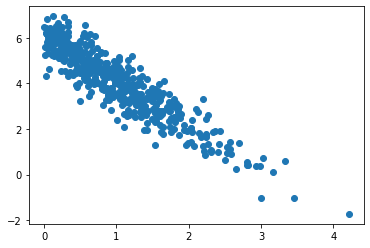

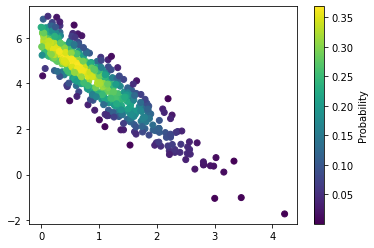

In [17]:
mu= torch.tensor([0.5, 5.0])
sigma = torch.tensor([1.0, 2.0])

rho = torch.tensor(-0.95)

dist_2d = ZLTN2D(mu, sigma, rho)

samples = dist_2d.sample((500,))
samples_numpy = samples.numpy()
plt.plot(samples_numpy[0], samples_numpy[1], 'o')
plt.show()

plt.scatter(samples_numpy[0], samples_numpy[1],c= torch.exp(dist_2d.log_prob(samples)).detach().numpy())
plt.colorbar(label = "Probability")
plt.show()

# plt.scatter(samples_numpy[0], samples_numpy[1],c= torch.exp(dist_2d.log_prob2(samples)).detach().numpy())
# plt.colorbar(label = "Probability")
# plt.show()

In [18]:
def model_2d(data):
  # mu = torch.tensor(0.1)

  prior_mu = torch.tensor([0.1, 0.9])
  prior_sigma = torch.tensor([0.2, 1.])
  prior_rho = torch.tensor(0.5)

  # mu = pyro.sample("mu", dist.Normal(0,1))
  # sigma = pyro.sample("sigma", dist.Normal(1,0.2))

  Av = pyro.sample("Av", ZLTN2D(prior_mu, prior_sigma, prior_rho))

In [19]:
def guide_2d(data): # truncated normal

  # mu_q1 = pyro.param("mu_q1", torch.tensor([0.]))
  # mu_q2 = pyro.param("mu_q2", torch.tensor([1.]))

  # sigma_q1 = pyro.param("sigma_q1", torch.tensor(0.5), constraint = constraints.positive) 
  # sigma_q2 = pyro.param("sigma_q2", torch.tensor(0.5), constraint = constraints.positive) 

  mu_q = pyro.param("mu_q", torch.tensor([0., 1.]))
  sigma_q = pyro.param("sigma_q", torch.tensor([0.5, 0.5]), 
                        constraint = constraints.positive)

  rho_q = pyro.param("rho_q", torch.tensor(0.6))
  # pyro.sample("mu", dist.Normal(mu_q,1))
  # pyro.sample("sigma", dist.Normal(sigma_q,0.2))
  # mu_q = pyro.param("mu_q", torch.tensor(0.1))
  # sigma_q = pyro.param("sigma_q", torch.tensor(0.9), 
  #                      constraint = constraints.positive)

  # pyro.sample("data", ZLTN2D(torch.stack((mu_q1, mu_q2)), torch.stack((sigma_q1, sigma_q2)), rho_q))
  Av = pyro.sample("Av", ZLTN2D(mu_q, sigma_q, rho_q))

In [20]:
train(model_2d, guide_2d, n_steps=50000, lr = 0.001)

[iter 0]  loss: 0.7757
[iter 1000]  loss: -0.4037
[iter 2000]  loss: -0.3542
[iter 3000]  loss: -0.6468
[iter 4000]  loss: 1.9203
[iter 5000]  loss: -0.2236
[iter 6000]  loss: 2.1419
[iter 7000]  loss: 5.0670
[iter 8000]  loss: -0.3387
[iter 9000]  loss: 0.0277
[iter 10000]  loss: -0.3860
[iter 11000]  loss: -0.0170
[iter 12000]  loss: -0.3581
[iter 13000]  loss: -0.3619
[iter 14000]  loss: -0.4231
[iter 15000]  loss: -0.3286
[iter 16000]  loss: 1.5754
[iter 17000]  loss: 3.3928
[iter 18000]  loss: 0.1108
[iter 19000]  loss: -0.1605
[iter 20000]  loss: -0.4239
[iter 21000]  loss: -0.4458
[iter 22000]  loss: -0.2569
[iter 23000]  loss: -0.1203
[iter 24000]  loss: -0.3493
[iter 25000]  loss: 0.6011
[iter 26000]  loss: 2.0221
[iter 27000]  loss: 0.8964
[iter 28000]  loss: 0.3249
[iter 29000]  loss: -0.5199
[iter 30000]  loss: 0.8397
[iter 31000]  loss: 0.4323
[iter 32000]  loss: -0.5092
[iter 33000]  loss: -0.4118
[iter 34000]  loss: 0.1541
[iter 35000]  loss: -0.4420
[iter 36000]  loss: 

In [21]:
mu_q = pyro.param("mu_q")
mu_q

tensor([0.1295, 0.9701], requires_grad=True)

In [22]:
for name in pyro.get_param_store().get_all_param_names():
    print(name, pyro.param(name).data.numpy())


mu_q [0.1295099 0.9700613]
sigma_q [0.37804967 1.264109  ]
rho_q 0.73633623


In [23]:
prior_mu = torch.tensor([0.1, 0.9])
prior_sigma = torch.tensor([0.2, 1.])
prior_rho = torch.tensor(0.5)
prior_distribution = ZLTN2D(prior_mu, prior_sigma, prior_rho)

posterior_mu = pyro.get_param_store()["mu_q"]
posterior_sigma = pyro.get_param_store()["sigma_q"]
posterior_rho = pyro.get_param_store()["rho_q"]

posterior_distribution = ZLTN2D(posterior_mu, posterior_sigma, posterior_rho)

In [24]:
prior_samples = prior_distribution.sample((5000,))
posterior_samples = posterior_distribution.sample((5000,))

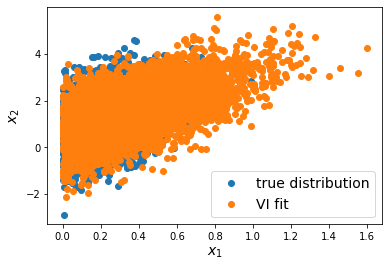

In [25]:
plt.plot(prior_samples[0], prior_samples[1], 'o', label = 'true distribution')
plt.plot(posterior_samples[0], posterior_samples[1], 'o', label = 'VI fit')
plt.legend(fontsize = 14)
plt.xlabel("$x_1$", fontsize = 14)
plt.ylabel("$x_2$", fontsize = 14)
plt.show()


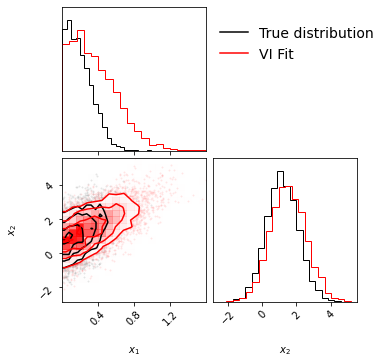

In [26]:
fig = corner.corner(prior_samples.numpy().T)
corner.corner(posterior_samples.numpy().T, color = 'r', fig = fig, labels = ['$x_1$', '$x_2$'])

colors = ['k','r']

labels = ['True distribution', 'VI Fit']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=14, frameon=False, bbox_to_anchor=(1.2, 2), loc="upper right"
)
plt.show()

In [390]:
from torch.distributions.multivariate_normal import MultivariateNormal

# This is a multivariate distribution where the first vector is ZLTN
# distributed, and all others are regular normal distributions
class ZLTN_ND(TorchDistribution):
    arg_constraints = {
        "mu": constraints.real_vector, # this is N-length vector
        "sigma": constraints.positive_definite, # this is an NxN matrix
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, mu, sigma, *, validate_args=None):
        # self.mu, self.sigma = broadcast_all(mu, sigma)
        self.mu = mu
        self.sigma = sigma
        self.mu_1 = torch.unsqueeze(torch.tensor([mu[0]]),1)
        self.sigma_11 = torch.unsqueeze(torch.tensor([sigma[0][0]]),0)
        self.base_dist = Normal(0, 1, validate_args=False)
        self.zltn_dist = ZLTN(mu[0], sigma[0][0])
        self.mu_2 = torch.unsqueeze(self.mu[1:],1)
        self.sigma_22 = self.sigma[1:, 1:]
        self.sigma_21 = self.sigma[1:, :1]
        self.sigma_12 = self.sigma[:1, 1:]
        batch_shape = torch.Size() if isinstance(mu, Number) else self.mu.size()
        super().__init__(batch_shape, validate_args=validate_args)

    def rsample(self, sample_shape=torch.Size()):
        mu_2_size = self.mu_2.size()[0] # number of other variables
        sample_size = sample_shape[0] if len(sample_shape) > 0 else 1 # number of samples of each variable

        normal_samples = self.base_dist.sample((mu_2_size, sample_size))
        first_samples = torch.unsqueeze(self.zltn_dist.sample(sample_shape),0)
        print(first_samples.shape)

        mu_2_size = self.mu_2.size()[0] # number of other variables
        sigma_11_inverse = torch.inverse(self.sigma_11)
        new_mu_1 = torch.broadcast_to(self.mu_1, first_samples.shape) if len(sample_shape) > 0 else self.mu_1

        # print(self.mu_2.size(), (mu_2_size, sample_size))
        mu_hat = torch.broadcast_to(self.mu_2, (mu_2_size, sample_size)) + torch.matmul(torch.matmul(self.sigma_21,sigma_11_inverse), (first_samples - self.mu_1))
        # print(mu_hat)
        # mu_hat = self.mu_2 + torch.squeeze(self.sigma_21*sigma_11_inverse*(first_samples - self.mu_1))
        # print(mu_hat.size())
        sigma_hat = self.sigma_22 - torch.matmul(torch.matmul(self.sigma_21,sigma_11_inverse), self.sigma_12)
        block_cov = torch.block_diag(*[sigma_hat for _ in range(sample_size)])
        second_samples = mu_hat + np.matmul(torch.linalg.cholesky(sigma_hat), normal_samples)

        # print(second_samples.shape)
        return torch.cat((first_samples, second_samples))

    def log_prob(self, value):
        log_prob_x = self.zltn_dist.log_prob(value[0])
        sigma_11_inverse = 1/torch.squeeze(self.sigma_11)
        # print("hello")

        # mu_hat = self.mu_2 + torch.squeeze(self.sigma_21*sigma_11_inverse*(value[0]- self.mu_1))
        mu_hat = self.mu_2 + self.sigma_21*sigma_11_inverse*(value[0]- self.mu_1)
        # print(self.mu_2.shape, mu_hat.shape)
        sigma_hat = self.sigma_22 - torch.matmul(self.sigma_21*sigma_11_inverse, self.sigma_12)
        # print(mu_hat.shape, sigma_hat.shape)
        # print(torch.unsqueeze(value[1:],0).shape)
        log_prob_y_given_x = MultivariateNormal(torch.squeeze(mu_hat), sigma_hat).log_prob(torch.unsqueeze(value[1:],0))
        return log_prob_x + log_prob_y_given_x

In [385]:
mu= torch.tensor([0.5, 5.0, 3.0])
cov = torch.tensor([[0.9, -0.7, -0.9], [-0.7, 1.0, 0.5], [0.5, -0.9, 1.0]])

z = ZLTN_ND(mu, cov)
samples = z.sample((5000,))

In [386]:
m = MultivariateNormal(mu, cov)
m.sample()

tensor([1.0050, 4.8742, 2.1548])

In [372]:
samples[0].shape

torch.Size([5000])

In [373]:
cov

tensor([[ 0.9000, -0.7000, -0.9000],
        [-0.7000,  1.0000,  0.5000],
        [ 0.5000, -0.9000,  1.0000]])

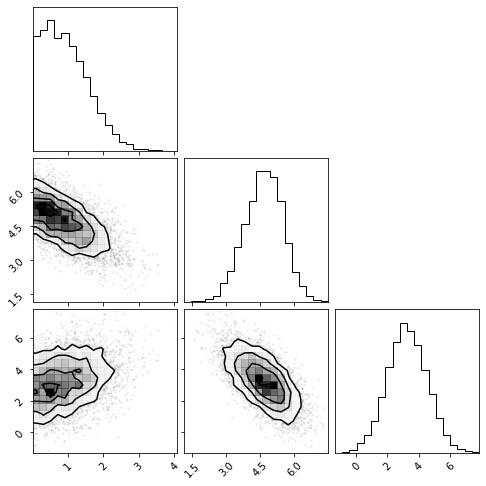

In [374]:
fig = corner.corner(samples.numpy().T)

In [375]:
def model_3d(data):
  prior_mus = torch.tensor([0.2, 0.9, 3.0])
  # prior_sigma = torch.tensor([0.2, 1.])
  prior_cov = torch.tensor([[0.9, -0.7, -0.9], [-0.7, 1.0, 0.5], [0.5, -0.9, 1.0]])
  # prior_rho = torch.tensor(0.5)

  # mu = pyro.sample("mu", dist.Normal(0,1))
  # sigma = pyro.sample("sigma", dist.Normal(1,0.2))

  Av = pyro.sample("Av", ZLTN_ND(prior_mu, prior_cov))

In [376]:
def guide_3d(data): # truncated normal

  mu_q = pyro.param("mu_q", torch.tensor([0., 1., 2.]))
  sigma_q = pyro.param("sigma_q", torch.tensor([[0.9, -0.7, -0.9], [-0.7, 1.0, 0.5], [0.5, -0.9, 1.0]]), 
                        constraint = constraints.positive_definite)

  Av = pyro.sample("Av", ZLTN_ND(mu_q, sigma_q))

In [391]:
train(model_3d, guide_3d, n_steps=50000, lr = 0.001)

torch.Size([1])


RuntimeError: ignored